## Extract text from notebooks
* Just markdown and source (maybe raw?)
* Use nbconvert to standardize version / extractions
* Keep cells in order
* TODO: which exceptions to catch?

In [87]:
import nbformat

NB_VERSION = 4

def extract_text(notebook_str):
    """ Extract code and markdown
    Args:
        * notebook_str - notebook as a string
    Returns:
        * str - select code and markdown source (and outputs)
    Pre:
        * notebook_str is well-formed per notebook version 4
        * 'cell_type' is defined for all cells
        * 'source' defined for all 'code' and 'markdown' cells
    Throws:
        * Anything nbformat.reads() can throw :( which is diverse and poorly
        documented, hence the `except Exception` in handler()
    Notes:
        * Deliberately decided not to index output streams and display strings
        because they were noisy and low value

    """
    formatted = nbformat.reads(notebook_str, as_version=NB_VERSION)
    text = []
    for cell in formatted.get('cells', []):
        if 'source' in cell and 'cell_type' in cell:
            if cell['cell_type'] == 'code' or cell['cell_type'] == 'markdown':
                text.append(cell['source'])

    return '\n'.join(text)

## Gather parseable notebooks in memory
If you have lots of notebooks or tiny amounts of RAM, use disk instead of RAM.

In [181]:
from os.path import basename
import glob
import traceback

nbs = glob.glob("./esnbs/*.ipynb")

good_nbs = []
for n in nbs:
    with open(n, 'r') as f:
        data = f.read()
        try:
            outstr = extract_text(data)
            good_nbs.append(n)
            fname = basename(n)
            with open(f"extracts/{fname}", "w+") as f:
                f.write(outstr)
        except Exception as e:
            print(f"skipping {n}")

## Build TF matrix, IDF vector

In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(input='filename', preprocessor=extract_text)
X = vectorizer.fit_transform(good_nbs)

> The vectorizer's vocabulary contains all words it encountered, minus stop words

### Peek at what vectorizer learned

> Omit digit strings, since our ElasticSearch endpoint doesn't index them.

In [156]:
import re
vocab = {t:i for t,i in vectorizer.vocabulary_.items() if not re.fullmatch('\d+', t)}
len(vocab)

163959

> It's a long list, so let's just peek at the first few.

In [157]:
import itertools
{k:v for k,v in itertools.islice(vocab.items(), 0, 10)}

{'distance': 75735,
 'wordList': 145416,
 'for': 84035,
 'dist': 75701,
 'in': 91934,
 'range': 120310,
 'update': 141563,
 'print': 117599,
 'nextWord': 107612,
 'None': 38144}

> `vocab` maps each term to an index in the `idf_` array

In [160]:
idf = vectorizer.idf_
idf[0:10]

array([4.38700625, 4.4723661 , 6.89026204, 7.47804871, 6.44842929,
       8.39433944, 9.08748662, 8.68202151, 9.08748662, 8.68202151])

### Map vocabulary to IDF

In [161]:
import pandas as pd

t2idf = {t:idf[i] for t,i in vocab.items()}
# put it in a pandas dataframe
t2idf_ = pd.DataFrame(list(term2idf.items()), columns=['term', 'idf'])

In [162]:
t2idf_.head()

,term,idf
0,distance,3.867131
1,wordList,8.394339
2,for,1.230780
3,dist,4.769999
4,in,1.209142


In [163]:
asc_idf = t2idf_.sort_values('idf')

### Terms with low IDF
Are super common, present in almost all docs

In [164]:
asc_idf.head(10)

,term,idf
94,import,1.135223
56,as,1.175613
4,in,1.209142
2,for,1.230780
35,from,1.253688
7,print,1.425960
30,and,1.461892
25,the,1.465312
128,data,1.491848
120,of,1.500683


### Terms with high IDF
Are idiosynchractic; unique to a single doc

In [188]:
asc_idf.tail(10)

,term,idf
114334,Gleicher,9.087487
114333,gebrauch,9.087487
114332,Integrierender,9.087487
114329,nsm,9.087487
114328,Linksorthokomplemet,9.087487
114326,aq2,9.087487
114325,aq1,9.087487
114323,Funktionen,9.087487
114335,Ansazu,9.087487
177051,VeraCrio13,9.087487


### See how IDFs are distributed

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77cf925e80>]],
      dtype=object)

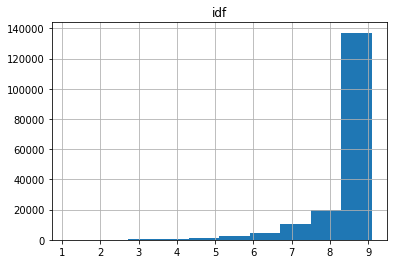

In [166]:
%matplotlib inline
asc_idf.hist(column='idf', bins=10)

### Grab 10 terms from each decile

In [179]:
import math
import numpy as np
import pickle

# flip the vocab so we can look up terms by index
i2t = {t:i for i,t in vocab.items()}
# sort by idf; only take terms in vocabulary
ascending_i = [i for i in np.argsort(idf) if i in i2t]

decile_size = math.floor(len(vocab) * .1)

decile_sample = {}
for d in range(0, 10):
    decile = ascending_i[decile_size * d: decile_size * (d+1)]
    random_i = np.random.choice(decile, 10, replace=False)
    decile_sample[d] = {i2t[j]:idf[j] for j in random_i}

with open("./dec_sample.pkl", 'wb') as f:
    pickle.dump(decile_sample, f)

In [180]:
decile_sample

{0: {'methods': 3.586228408390312,
  'resulting': 4.424047524822972,
  'basin': 6.22528573800557,
  'OSError': 7.295727149706984,
  'Sal': 7.072583598392774,
  'MAE': 6.602579969147039,
  'traverse': 7.008045077255203,
  'Independent': 6.645139583565834,
  'модель': 5.888813501384357,
  'processed': 5.621750716135312},
 1: {'zero_with_resv': 7.8347236504396705,
  'discount_factor': 7.988874330266929,
  'scale_color_brewer': 7.701192257815148,
  'nonzeroy': 7.478048706500939,
  'Пока': 7.583409222158765,
  'contemporary': 7.701192257815148,
  'train_lgb': 7.8347236504396705,
  'unlearned': 7.8347236504396705,
  'firstnum': 7.478048706500939,
  'Suspects': 7.988874330266929},
 2: {'Gott': 8.171195887060883,
  'occupants': 8.394339438375093,
  'dirpath': 8.171195887060883,
  'Remarque': 8.171195887060883,
  'set_next': 8.394339438375093,
  'delta_price1': 8.394339438375093,
  'numRows此圖合併了幾行': 8.171195887060883,
  'wordCountsGrouped': 8.171195887060883,
  'vocab_dict': 8.394339438375093,


> Neat. Good mix of languages (Russian, Chinese, English, German), numbers, variables, plain text.